## **LoRA (Low-Rank Adaptation)**

#### **Khái niệm chính:**
LoRA là một kỹ thuật fine-tune hiệu quả về tham số, giúp huấn luyện các mô hình ngôn ngữ lớn mà không cần cập nhật toàn bộ trọng số. Thay vào đó, **LoRA đóng băng trọng số gốc** và chỉ huấn luyện **các ma trận hạng thấp (low-rank matrices)** được thêm vào tại các lớp attention.

---

#### **Cách hoạt động:**
- **Chèn thêm hai ma trận hạng thấp** vào các lớp attention của transformer.
- Các ma trận này mô hình hóa sự thay đổi cần thiết mà không làm thay đổi toàn bộ trọng số gốc.
- Khi inference, các trọng số adapter có thể được *gộp (merge)* lại với mô hình gốc → không thêm độ trễ.

---

#### **Hiệu quả tài nguyên:**
- **Giảm tới ~90% số tham số cần huấn luyện.**
- Trên GPT-3 (175B), LoRA giúp giảm **10,000 lần số tham số cần huấn luyện** và **3 lần bộ nhớ GPU sử dụng** so với full fine-tuning.

---

#### **Lợi ích chính của LoRA:**

| Nhóm lợi ích       | Mô tả                                                                 |
|-------------------|----------------------------------------------------------------------|
| **Hiệu quả bộ nhớ** | Chỉ lưu adapter trong GPU, trọng số gốc có thể dùng ở định dạng nén |
| **Dễ triển khai**   | Tích hợp tốt với PEFT (Parameter-Efficient Fine-Tuning), dễ dùng   |
| **Hỗ trợ QLoRA**    | Có thể kết hợp với mô hình nén (quantized) để tiết kiệm thêm       |
| **Quản lý adapter** | Cho phép lưu riêng adapter, hoặc gộp chúng lại vào mô hình gốc     |

---

#### **Ứng dụng điển hình:**
- Tinh chỉnh LLMs cho các tác vụ đặc thù (ví dụ: dịch thuật, trả lời câu hỏi chuyên ngành).
- Fine-tuning mô hình lớn như LLaMA, Falcon, Mistral, GPT-NeoX… trên máy có GPU giới hạn (như RTX 3090, 4090…).

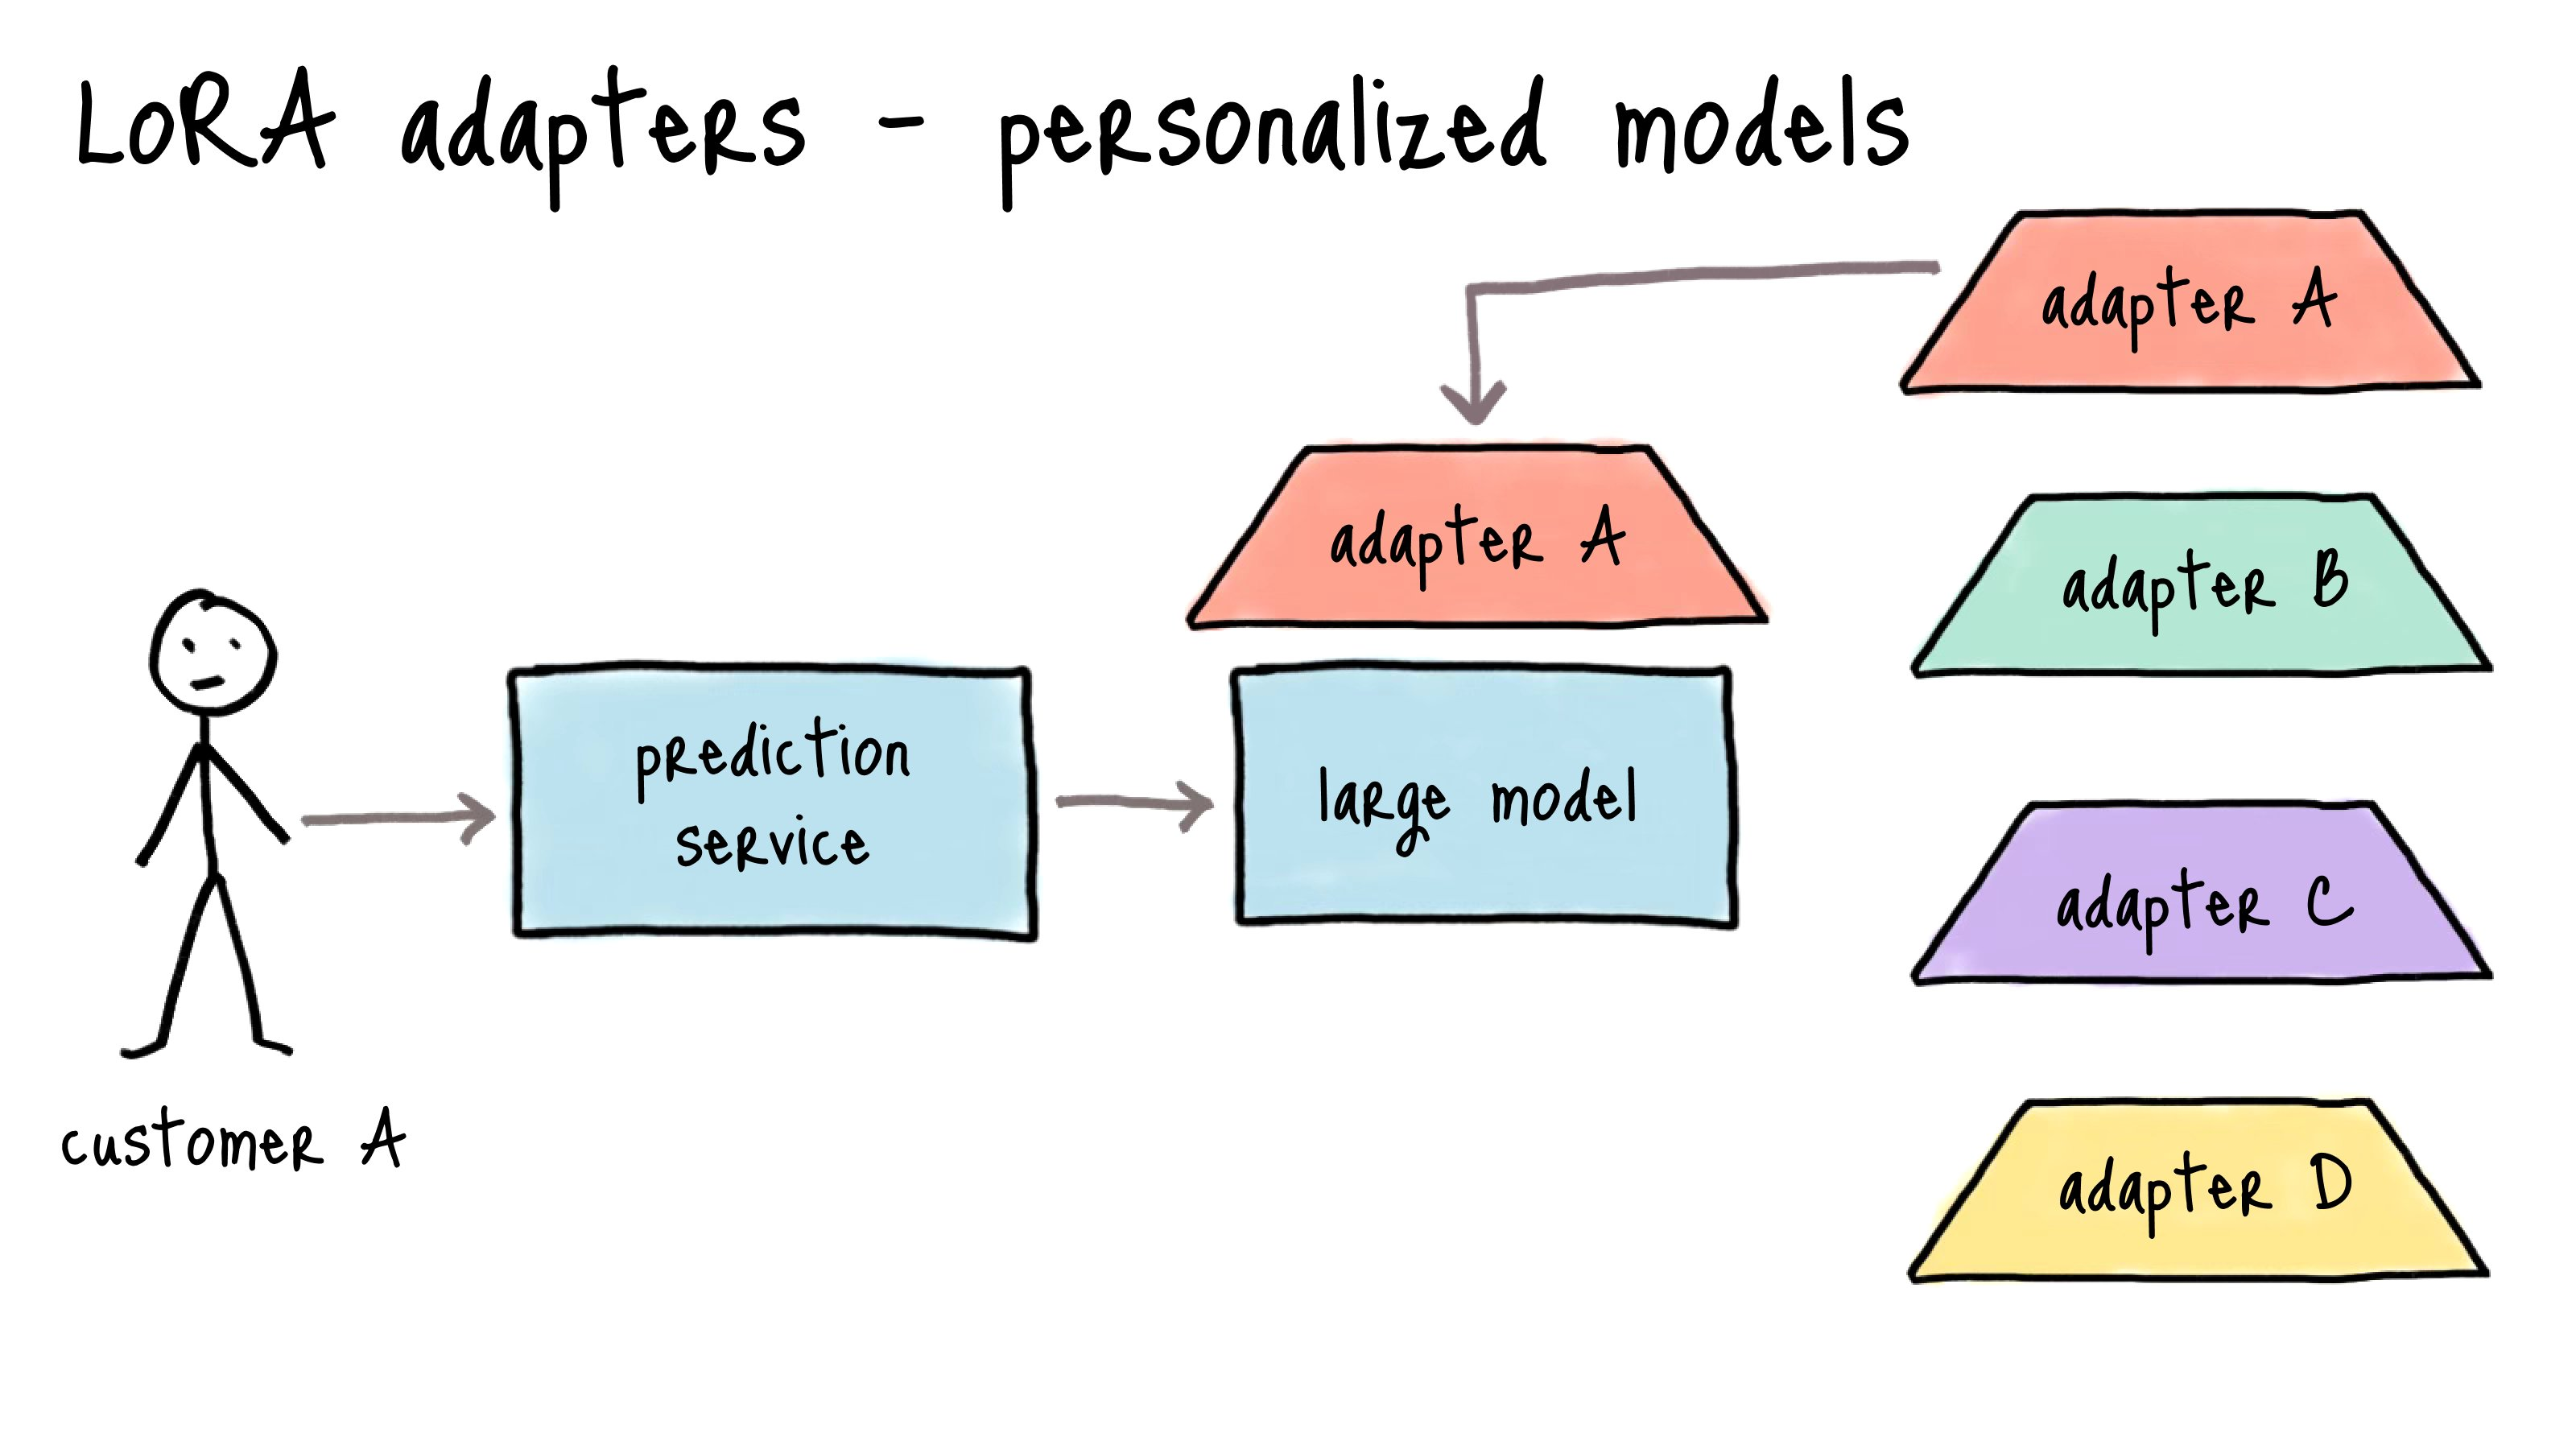
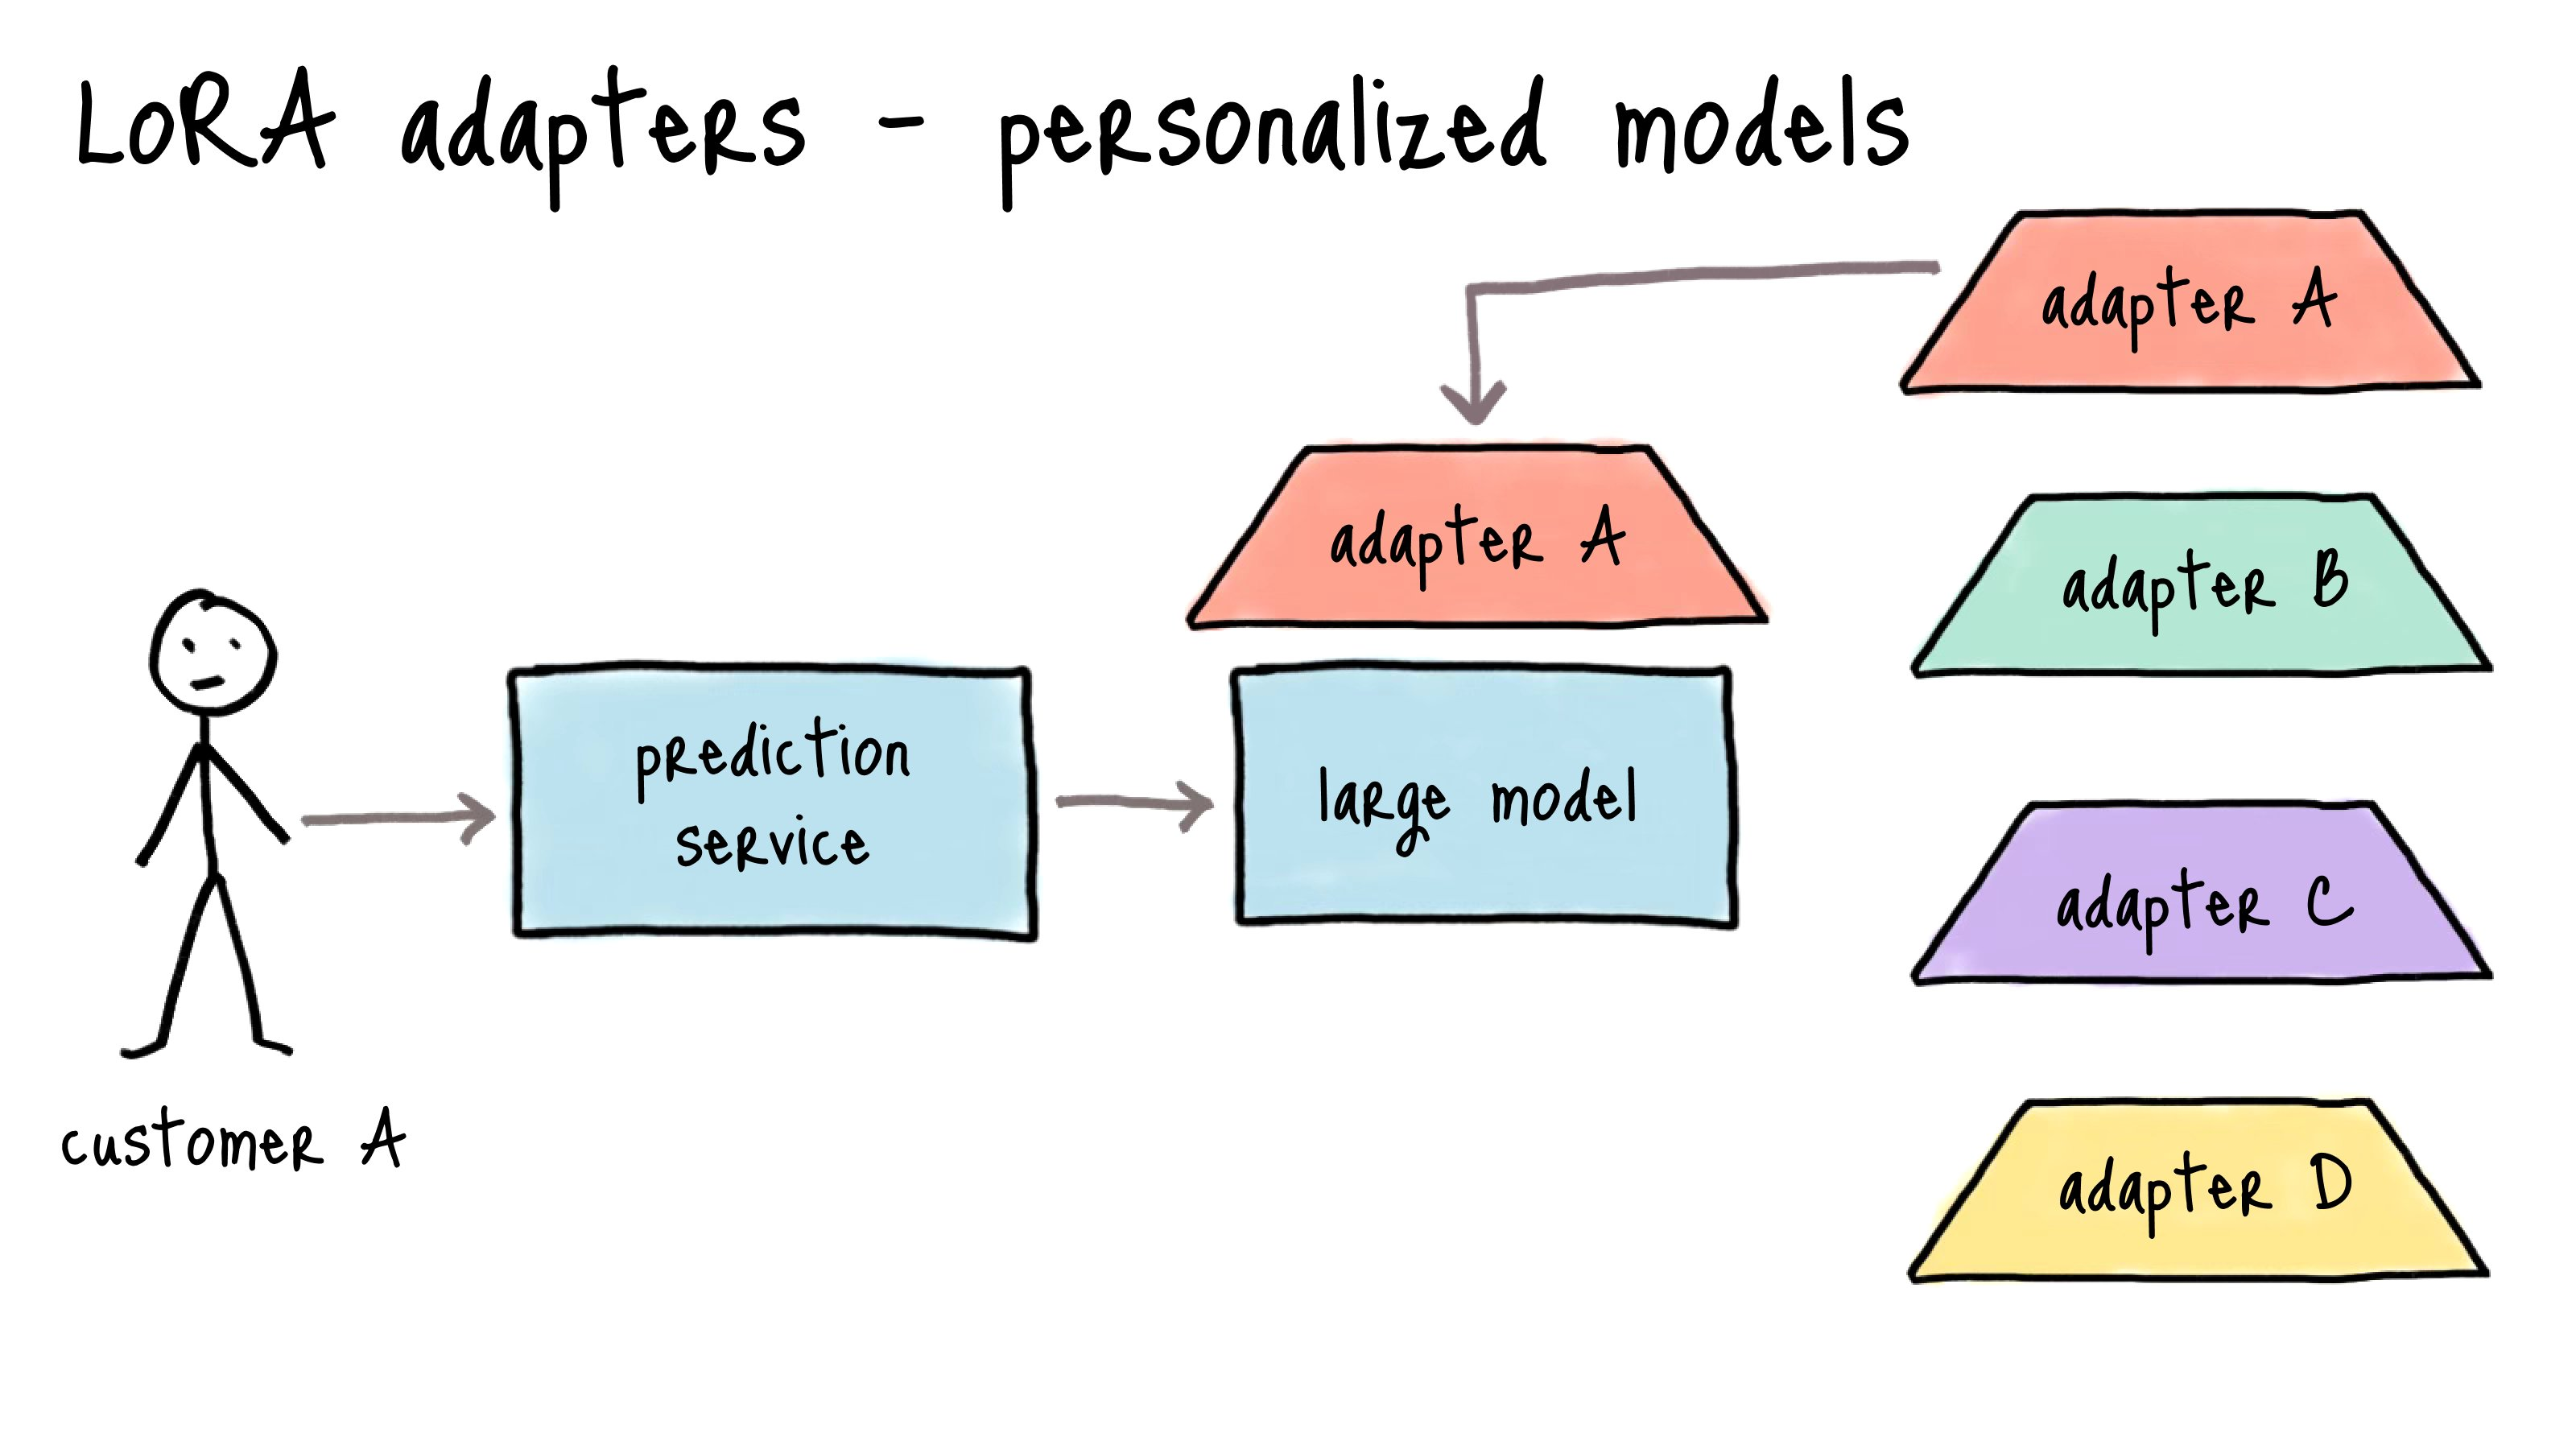

## **Loading LoRA Adapters with PEFT**


In [ ]:
from peft import PeftModel, PeftConfig

config = PeftConfig.from_pretrained("ybelkada/opt-350m-lora")
model = AutoModelForCausalLM.from_pretrained(config.base_model_name_or_path)
lora_model = PeftModel.from_pretrained(model, "ybelkada/opt-350m-lora")

### **LoRA Configuration**

| **Tham số**        | **Mô tả** |
|--------------------|-----------|
| **`r` (rank)**     | Là bậc của các ma trận hạng thấp được sử dụng để cập nhật trọng số. Thường nằm trong khoảng từ **4 đến 32**. Giá trị thấp giúp giảm chi phí bộ nhớ nhưng có thể làm giảm khả năng biểu diễn của mô hình. |
| **`lora_alpha`**   | Là hệ số nhân để điều chỉnh mức ảnh hưởng của các lớp LoRA. Thường được đặt bằng **2×r**. Giá trị cao hơn giúp mô hình thích nghi mạnh mẽ hơn nhưng có thể gây quá khớp nếu quá lớn. |
| **`lora_dropout`** | Xác suất dropout áp dụng cho các lớp LoRA, thường nằm trong khoảng **0.05 đến 0.1**. Giá trị cao hơn giúp **giảm nguy cơ overfitting** trong quá trình huấn luyện. |
| **`bias`**         | Quy định xem có huấn luyện các tham số bias không. Gồm ba lựa chọn: <br> - `"none"`: Không huấn luyện bias (phổ biến nhất, tiết kiệm bộ nhớ). <br> - `"all"`: Huấn luyện tất cả bias. <br> - `"lora_only"`: Chỉ huấn luyện bias ở các lớp có áp dụng LoRA. |
| **`target_modules`** | Xác định **những module nào trong mô hình sẽ áp dụng LoRA**. Có thể là: <br> - `"all-linear"`: Áp dụng cho tất cả các lớp tuyến tính. <br> - Cụ thể như `"q_proj,v_proj"`: Chỉ áp dụng cho các lớp attention projection. <br> Càng nhiều module được chọn, mô hình càng thích nghi tốt nhưng sẽ **tăng mức sử dụng bộ nhớ**. |


### **Using TRL with PEFT**


In [1]:
from peft import LoraConfig

# TODO: Configure LoRA parameters

# r: rank dimension for LoRA update matrices (smaller = more compression)
rank_dimension = 6
# lora_alpha: scaling factor for LoRA layers (higher = stronger adaptation)
lora_alpha = 8
# lora_dropout: dropout probability for LoRA layers (helps prevent overfitting)
lora_dropout = 0.05

peft_config = LoraConfig(
    r=rank_dimension,  # Rank dimension - typically between 4-32
    lora_alpha=lora_alpha,  # LoRA scaling factor - typically 2x rank
    lora_dropout=lora_dropout,  # Dropout probability for LoRA layers
    bias="none",  # Bias type for LoRA. the corresponding biases will be updated during training.
    target_modules="all-linear",  # Which modules to apply LoRA to
    task_type="CAUSAL_LM",  # Task type for model architecture
)

2025-04-17 13:51:20.037353: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744897880.301452      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744897880.376039      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# Create SFTTrainer with LoRA configuration
trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=dataset["train"],
    peft_config=peft_config,  # LoRA configuration
    max_seq_length=max_seq_length,  # Maximum sequence length
    processing_class=tokenizer,
)

### **Merging LoRA Adapters**

Sau khi huấn luyện xong mô hình với LoRA, ta có thể **gộp trọng số của adapter vào mô hình gốc** nhằm tạo ra một mô hình duy nhất, không cần tải adapter riêng khi suy luận (inference). Việc này giúp đơn giản hoá quá trình triển khai (deployment) và tăng tốc độ suy luận.

---

#### 1. **Tải đồng thời mô hình gốc và adapter**
Bạn cần tải cả hai:
- Mô hình gốc (base model)
- Trọng số LoRA adapter đã huấn luyện

**Lưu ý bộ nhớ**:
- Cần đảm bảo đủ RAM/GPU memory vì cả hai thành phần sẽ được giữ trong bộ nhớ khi merge.
- Dùng `device_map="auto"` với Hugging Face `transformers` để tự động phân bổ mô hình theo tài nguyên phần cứng sẵn có.

#### 2. **Giữ nguyên độ chính xác (Precision)**
- Nếu bạn huấn luyện với **float16**, thì cần duy trì float16 xuyên suốt quá trình merge và lưu mô hình.
- Tránh chuyển đổi giữa float16 ↔ float32 vì có thể gây sai lệch trọng số.

#### **Merging Implementation**

In [ ]:
import torch
from transformers import AutoModelForCausalLM
from peft import PeftModel

# 1. Load the base model
base_model = AutoModelForCausalLM.from_pretrained(
    "base_model_name", torch_dtype=torch.float16, device_map="auto"
)

# 2. Load the PEFT model with adapter
peft_model = PeftModel.from_pretrained(
    base_model, "path/to/adapter", torch_dtype=torch.float16
)

# 3. Merge adapter weights with base model
merged_model = peft_model.merge_and_unload()

# Save both model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("base_model_name")
merged_model.save_pretrained("path/to/save/merged_model")
tokenizer.save_pretrained("path/to/save/merged_model")